# Tennis Players Pose Estimation




## 00. Setup

In [1]:
!nvidia-smi

Mon Feb 16 16:06:25 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   60C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Fri_Feb_21_20:23:50_PST_2025
Cuda compilation tools, release 12.8, V12.8.93
Build cuda_12.8.r12.8/compiler.35583870_0
torch:  2.9 ; cuda:  cu128


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


### YOLOv7

In [4]:
!pip install ultralytics
from ultralytics import YOLO
from IPython import display
display.clear_output()
import ultralytics
ultralytics.checks()

Ultralytics 8.4.14 🚀 Python-3.12.12 torch-2.9.0+cu128 CUDA:0 (Tesla T4, 14913MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.6/112.6 GB disk)


## 01. Download data

In [5]:
SOURCE_VIDEO_A_PATH = os.path.join(HOME, 'videos', 'sampleVideo1.mp4')
SOURCE_VIDEO_B_PATH = os.path.join(HOME, 'videos', 'sampleVideo2.mp4')
SOURCE_VIDEO_C_PATH = os.path.join(HOME, 'videos', 'sampleVideo3.mp4')
SOURCE_VIDEO_TEST_PATH_1 = os.path.join(HOME, 'videos', 'sampleVideo3.mp4')
SOURCE_VIDEO_TEST_PATH_2 = os.path.join(HOME, 'videos', 'sampleVideo5.mp4')

## 02. Utils

In [6]:
from typing import Generator

import matplotlib.pyplot as plt
import numpy as np

import cv2

%matplotlib inline


def generate_frames(video_file: str) -> Generator[np.ndarray, None, None]:
    video = cv2.VideoCapture(video_file)

    while video.isOpened():
        success, frame = video.read()

        if not success:
            break

        yield frame

    video.release()


def plot_image(image: np.ndarray, size: int = 12) -> None:
    plt.figure(figsize=(size, size))
    plt.axis('off')
    plt.imshow(image[...,::-1])
    plt.show()

In [7]:
from typing import Optional, Tuple
from dataclasses import dataclass


@dataclass(frozen=True)
class Point:
    x: float
    y: float

    @property
    def int_xy_tuple(self) -> Tuple[int, int]:
        return int(self.x), int(self.y)


@dataclass(frozen=True)
class Rect:
    x: float
    y: float
    width: float
    height: float

    @property
    def top_left(self) -> Point:
        return Point(x=self.x, y=self.y)

    @property
    def bottom_right(self) -> Point:
        return Point(x=self.x + self.width, y=self.y + self.height)

    @property
    def bottom_center(self) -> Point:
        return Point(x=self.x + self.width / 2, y=self.y + self.height)

@dataclass
class Detection:
    rect: Rect
    class_id: int
    confidence: float
    tracker_id: Optional[int] = None


@dataclass(frozen=True)
class Color:
    r: int
    g: int
    b: int

    @property
    def bgr_tuple(self) -> Tuple[int, int, int]:
        return self.b, self.g, self.r

In [8]:
import cv2

import numpy as np

def draw_rect(image: np.ndarray, rect: Rect, color: Color, thickness: int = 2) -> np.ndarray:
    cv2.rectangle(image, rect.top_left.int_xy_tuple, rect.bottom_right.int_xy_tuple, color.bgr_tuple, thickness)
    return image

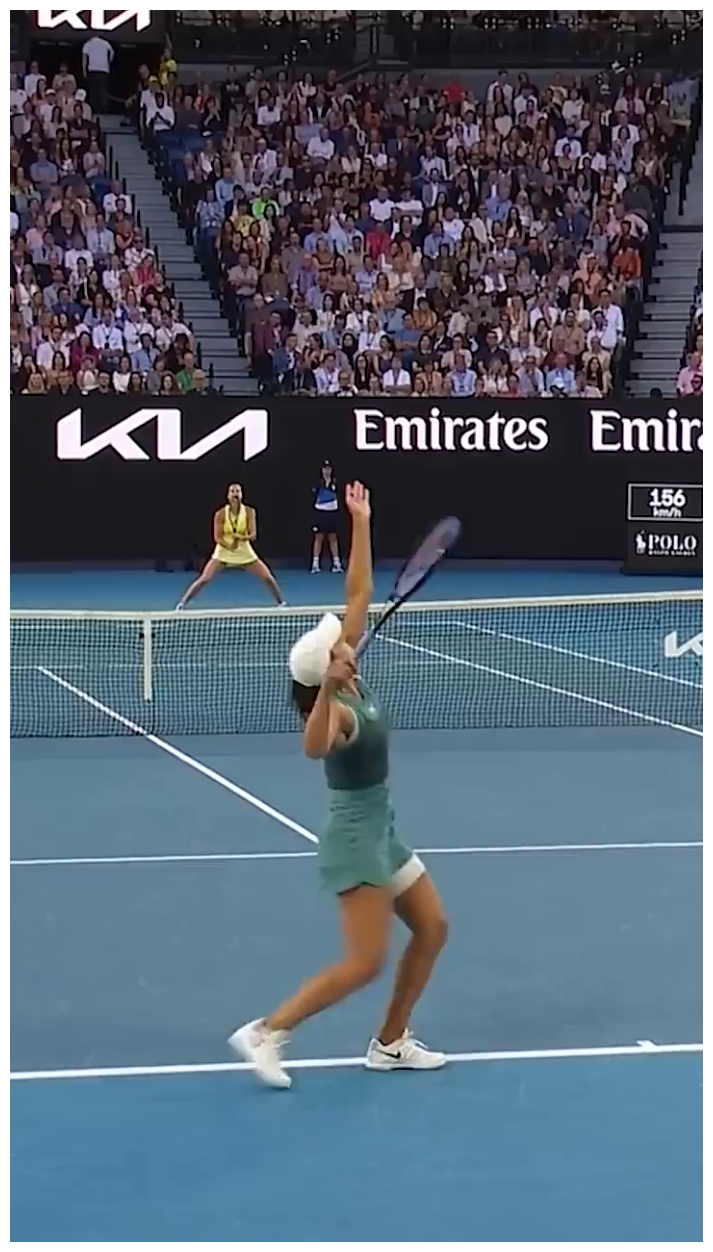

In [10]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_C_PATH))

frame = next(frame_iterator)
plot_image(frame, 16)

## 03. Load YOLOv8 Pose model

### Download weights

In [11]:
MODEL_PATH = 'yolov8n-pose.pt'

In [12]:
MODEL_PATH = 'yolov8n-pose.pt'

In [13]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Load detection model

In [14]:
model = YOLO(MODEL_PATH)

## 05. Single frame inference

### Settings

In [15]:
DETECTION_IMAGE_SIZE = 1920
POSE_IMAGE_SIZE = 960
STRIDE = 64
CONFIDENCE_TRESHOLD = 0.25
IOU_TRESHOLD = 0.65

### Annotate

In [16]:
def detect_annotate(image: np.ndarray, detections: np.ndarray, color: Color, thickness: int = 2) -> np.ndarray:
    annotated_image = image.copy()
    for x_min, y_min, x_max, y_max, confidence, class_id in detections:
        rect = Rect(
            x=float(x_min),
            y=float(y_min),
            width=float(x_max - x_min),
            height=float(y_max - y_min)
        )
        annotated_image = draw_rect(image=annotated_image, rect=rect, color=color, thickness=thickness)

    return annotated_image


def pose_annotate(image: np.ndarray, detections: np.ndarray) -> np.ndarray:
    annotated_frame = image.copy()

    for idx in range(detections.shape[0]):
        pose = detections[idx, 7:].T
        plot_skeleton_kpts(annotated_frame, pose, 3)

    return annotated_frame


### Single frame detection


0: 640x384 2 persons, 79.0ms
Speed: 10.7ms preprocess, 79.0ms inference, 42.1ms postprocess per image at shape (1, 3, 640, 384)


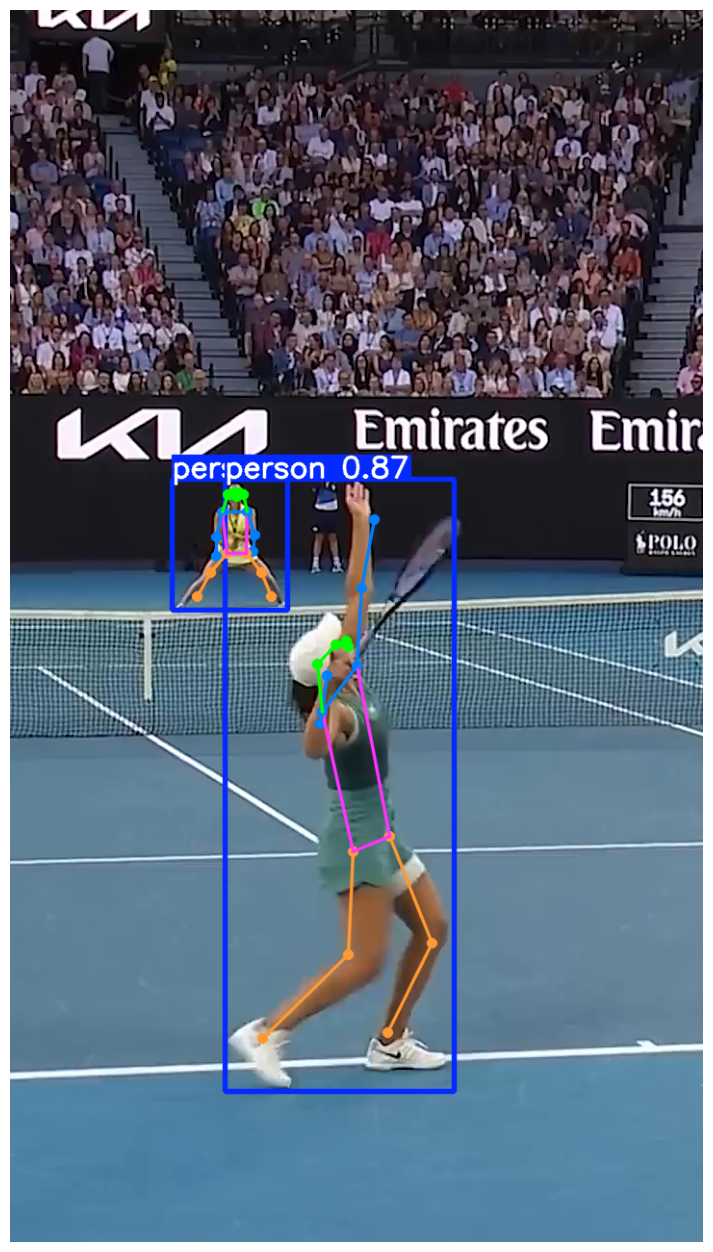

In [17]:
# Single frame inference with YOLOv8
results = model(frame)[0]
annotated_frame = results.plot()
plot_image(annotated_frame, 16)

### Single frame pose

In [18]:
def process_frame_and_annotate(frame: np.ndarray) -> np.ndarray:
    results = model(frame)
    annotated_frame = results[0].plot()
    return annotated_frame

    with torch.no_grad():
        pose_output, _ = pose_model(pose_pre_processed_frame)
        pose_output = pose_post_process_output(
            output=pose_output,
            confidence_trashold=CONFIDENCE_TRESHOLD,
            iou_trashold=IOU_TRESHOLD,
            image_size=image_size,
            scaled_image_size=scaled_image_size
        )

    annotated_frame = pose_annotate(image=frame, detections=pose_output)

    return annotated_frame


0: 640x384 2 persons, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


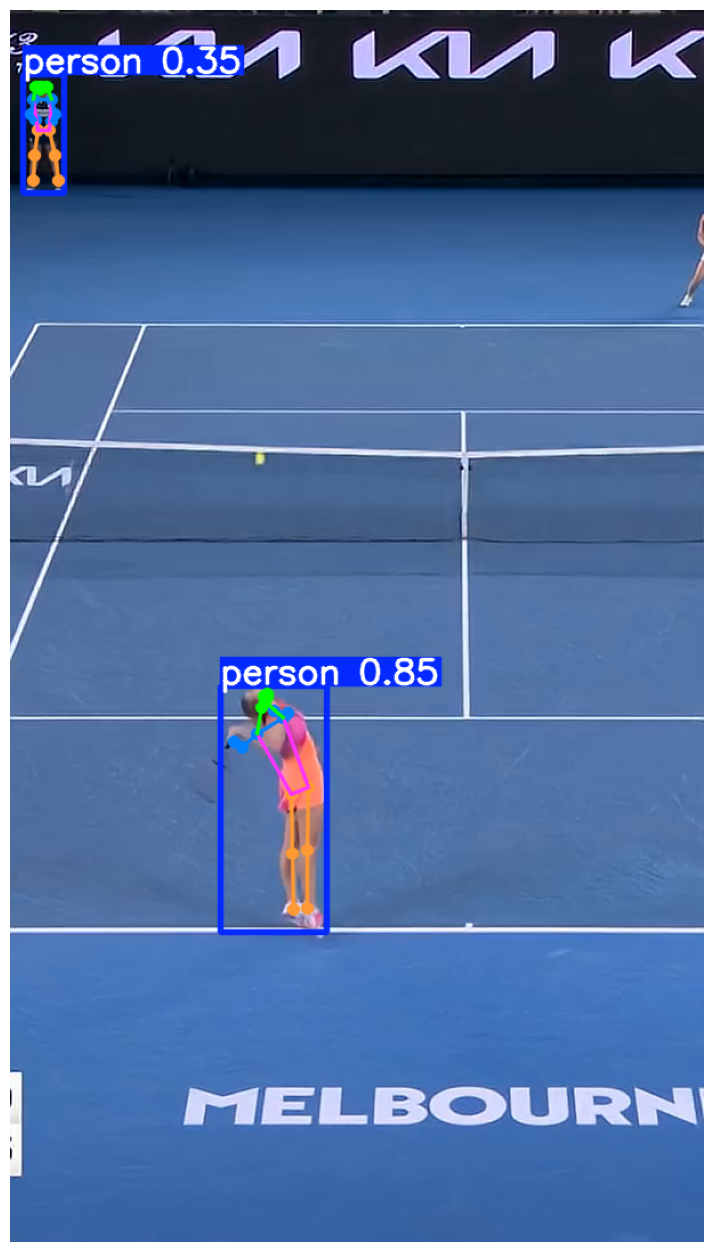

In [19]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_A_PATH))
frame = next(frame_iterator)
annotated_frame = process_frame_and_annotate(frame=frame)
plot_image(annotated_frame, 16)


0: 640x384 1 person, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


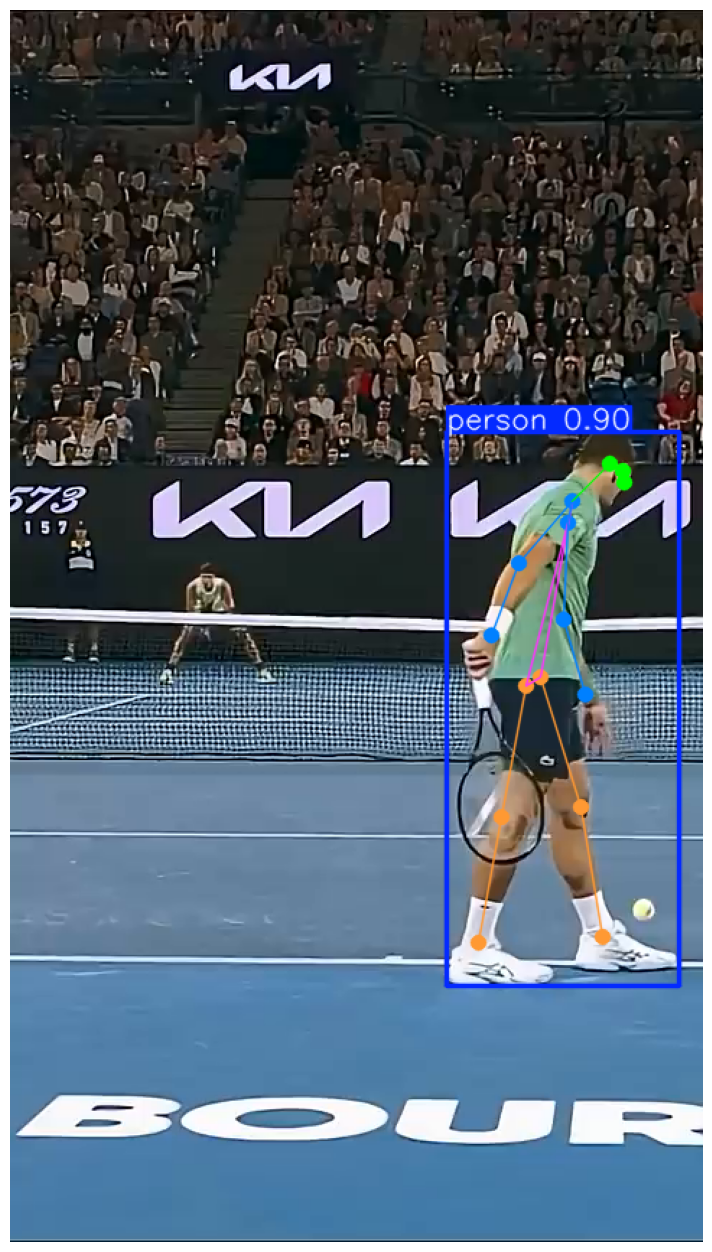

In [20]:
frame_iterator = iter(generate_frames(video_file=SOURCE_VIDEO_B_PATH))
frame = next(frame_iterator)
annotated_frame = process_frame_and_annotate(frame=frame)
plot_image(annotated_frame, 16)

## 04. Process video

In [21]:
from dataclasses import dataclass
import cv2

# stores information about output video file, width and height of the frame must be equal to input video
@dataclass(frozen=True)
class VideoConfig:
    fps: float
    width: int
    height: int


# create cv2.VideoWriter object that we can use to save output video
def get_video_writer(target_video_path: str, video_config: VideoConfig) -> cv2.VideoWriter:
    video_target_dir = os.path.dirname(os.path.abspath(target_video_path))
    os.makedirs(video_target_dir, exist_ok=True)
    return cv2.VideoWriter(
        target_video_path,
        fourcc=cv2.VideoWriter_fourcc(*"mp4v"),
        fps=video_config.fps,
        frameSize=(video_config.width, video_config.height),
        isColor=True
    )


def get_frame_count(path: str) -> int:
    cap = cv2.VideoCapture(SOURCE_VIDEO_A_PATH)
    return int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

In [29]:
import cv2
import os

SOURCE_VIDEO_PATH = SOURCE_VIDEO_B_PATH
TARGET_VIDEO_PATH = f"{HOME}/output/pose-estimation-synchronised-sample-b.mp4"

os.makedirs(os.path.dirname(TARGET_VIDEO_PATH), exist_ok=True)

cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)

fps = int(cap.get(cv2.CAP_PROP_FPS))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(TARGET_VIDEO_PATH, fourcc, fps, (width, height))

print("VideoWriter opened:", out.isOpened())

while True:
    ret, frame = cap.read()
    if not ret:
        break

    annotated_frame = process_frame_and_annotate(frame)
    out.write(annotated_frame)

cap.release()
out.release()

print("Saved video to:", TARGET_VIDEO_PATH)

VideoWriter opened: True

0: 640x384 1 person, 10.1ms
Speed: 3.2ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 11.8ms
Speed: 3.2ms preprocess, 11.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.2ms postprocess per image at sh